# This notebook plots OBS MCS rain fraction map and regional mean barchart from different trackers
## Figures produced in the MCSMIP paper:
- Figure 5
- Figure 7
- Figure 8
- Figure S4
- Figure S5
## The data is produced by:
- /src/calc_tbpf_mcs_rainmap_mcsmip.py

In [50]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
import colorcet as cc
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
import copy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
%matplotlib inline

In [51]:
# PHASE = 'Summer'
PHASE = 'Winter'

source = 'OBS'
# source = 'OBSv7'

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'
dir_PyFLEXTRKR = f'{rootdir}PyFLEXTRKR/'
dir_MOAAP = f'{rootdir}MOAAP/'
dir_TOOCAN = f'{rootdir}TOOCAN/'
dir_tobac = f'{rootdir}tobac/'
dir_TAMS = f'{rootdir}TAMS/'
dir_simpleTrack = f'{rootdir}simpleTrack/'
dir_KFyAO = f'{rootdir}KFyAO/'
dir_DL = f'{rootdir}DL/'
dir_TIMPS = f'{rootdir}TIMPS/'
dir_ATRACKCS = f'{rootdir}ATRACKCS/'

dict_filenames = {
    'PyFLEXTRKR': f'{dir_PyFLEXTRKR}mcs_rainmap_{PHASE}_{source}.nc',
    'DL': f'{dir_DL}mcs_rainmap_{PHASE}_{source}.nc',
    'MOAAP': f'{dir_MOAAP}mcs_rainmap_{PHASE}_{source}.nc',
    'TOOCAN': f'{dir_TOOCAN}mcs_rainmap_{PHASE}_{source}.nc',
    'tobac': f'{dir_tobac}mcs_rainmap_{PHASE}_{source}.nc',
    'TIMPS': f'{dir_TIMPS}mcs_rainmap_{PHASE}_{source}.nc',
    'simpleTrack': f'{dir_simpleTrack}mcs_rainmap_{PHASE}_{source}.nc',
    'KFyAO': f'{dir_KFyAO}mcs_rainmap_{PHASE}_{source}.nc',
    'TAMS': f'{dir_TAMS}mcs_rainmap_{PHASE}_{source}.nc',
    'ATRACKCS': f'{dir_ATRACKCS}mcs_rainmap_{PHASE}_{source}.nc',
}

# dict_filenames = {
#     'PyFLEXTRKR': f'{dir_PyFLEXTRKR}mcs_rainmap_{PHASE}_{source}.nc',
#     'MOAAP': f'{dir_MOAAP}mcs_rainmap_{PHASE}_{source}.nc',
#     'TOOCAN': f'{dir_TOOCAN}mcs_rainmap_{PHASE}_{source}.nc',
#     'tobac': f'{dir_tobac}mcs_rainmap_{PHASE}_{source}.nc',
#     'TAMS': f'{dir_TAMS}mcs_rainmap_{PHASE}_{source}.nc',
#     'simpleTrack': f'{dir_simpleTrack}mcs_rainmap_{PHASE}_{source}.nc',
#     'DL': f'{dir_DL}mcs_rainmap_{PHASE}_{source}.nc',
#     'KFyAO': f'{dir_KFyAO}mcs_rainmap_{PHASE}_{source}.nc',
#     'TIMPS': f'{dir_TIMPS}mcs_rainmap_{PHASE}_{source}.nc',
#     'ATRACKCS': f'{dir_ATRACKCS}mcs_rainmap_{PHASE}_{source}.nc',
# }

filenames = list(dict_filenames.values())
tracker_list = list(dict_filenames.keys())

topfile = '/global/cfs/cdirs/m1867/zfeng/gpm/map_data/era5_orography.nc'
landmaskfile = '/pscratch/sd/f/feng045/DYAMOND/maps/IMERG_landmask_180W-180E_60S-60N.nc'
obstbcountfile = f'/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined/{PHASE}_OBS_validcount.nc'

# Threshold missing Tb data fraction
miss_frac = 70.0  # [%]

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/


## Check if input files exist

In [52]:
for key, value in dict_filenames.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/PyFLEXTRKR/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/DL/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/MOAAP/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TOOCAN/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/tobac/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TIMPS/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/simpleTrack/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/KFyAO/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/TAMS/mcs_rainmap_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Winter/ATRACKCS/mcs_rainmap_Winter_OBS.nc: True


# These customed functions enables use of [NCL colormaps](https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml)

In [53]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

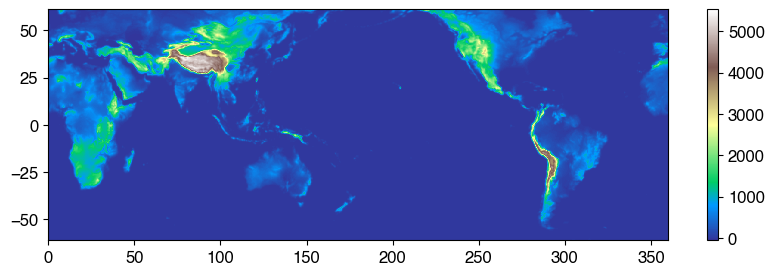

In [54]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.z.sel(latitude=slice(61,-61)).squeeze() / 9.80665
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.longitude
lat_ter = dstop.latitude.sel(latitude=slice(61,-61))

fig = plt.figure(figsize=[10,3], dpi=100)
plt.pcolormesh(lon_ter, lat_ter, ter_s, cmap='terrain')
plt.colorbar()

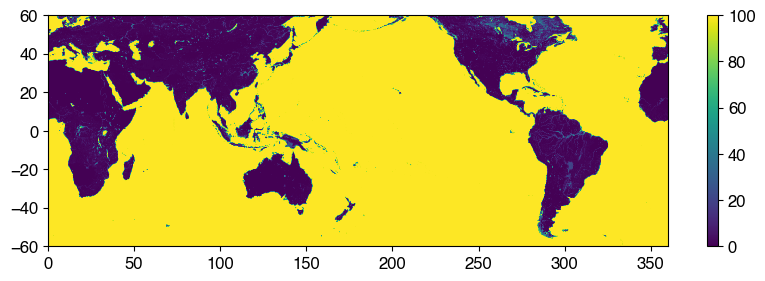

In [55]:
# Read landmask data
dslm = xr.open_dataset(landmaskfile)
# lon_lm = dslm['lon']
# lat_lm = dslm['lat']
# dslm = dslm.assign_coords(lon=lon_obs)
# dslm = dslm.assign_coords(lat=lat_obs)
if PHASE == 'Winter':
    dslm = dslm.roll(lon=1800, roll_coords=True)
    # Convert longitude coordinates from -180~180 to 0~360
    lon360 = dslm['lon'].data % 360
    dslm = dslm.assign_coords(lon=lon360)
#     dslm = dslm.roll(lon=1800, roll_coords=True)
#     dslm = dslm.assign_coords(lon=lon_obs)
#     dslm = dslm.assign_coords(lat=lat_obs)

lon_lm = dslm['lon']
lat_lm = dslm['lat']
landmask = dslm.landseamask
fig = plt.figure(figsize=[10,3], dpi=100)
plt.pcolormesh(lon_lm, lat_lm, landmask)
plt.colorbar()

In [59]:
# Read OBS Tb valid count data
dstb = xr.open_dataset(obstbcountfile)

if PHASE == 'Winter':
    dstb = dstb.roll(lon=1800, roll_coords=True)
    # Convert longitude coordinates from -180~180 to 0~360
    lon360 = dstb['lon'].data % 360
    dstb = dstb.assign_coords(lon=lon360)

# dstb = dstb.assign_coords({'lon': lon_lm, 'lat': lat_lm})
dstb

<xarray.Dataset>
Dimensions:      (lat: 1200, lon: 3600)
Coordinates:
  * lon          (lon) float64 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 359.9
  * lat          (lat) float64 -59.95 -59.85 -59.75 -59.65 ... 59.75 59.85 59.95
Data variables:
    valid_count  (lat, lon) int64 959 959 959 959 959 ... 959 959 960 960 960
Attributes:
    title:         Winter OBS valid Tb data counts
    total_ntimes:  960
    contact:       Zhe Feng, zhe.feng@pnnl.gov
    created_on:    Wed Mar 27 09:44:31 2024

In [60]:
# Calculate valid data fraction
valid_frac = 100 * dstb.valid_count / dstb.attrs['total_ntimes']
# Create a mask for significant missing Tb data
mask_miss = valid_frac < miss_frac

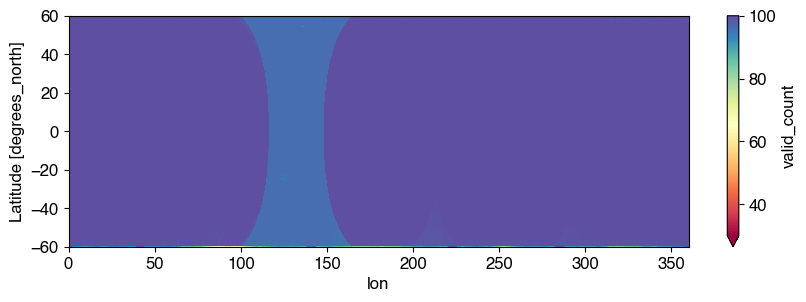

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10,3), dpi=100)
valid_frac.plot(vmin=30, vmax=100, cmap='Spectral', ax=ax)

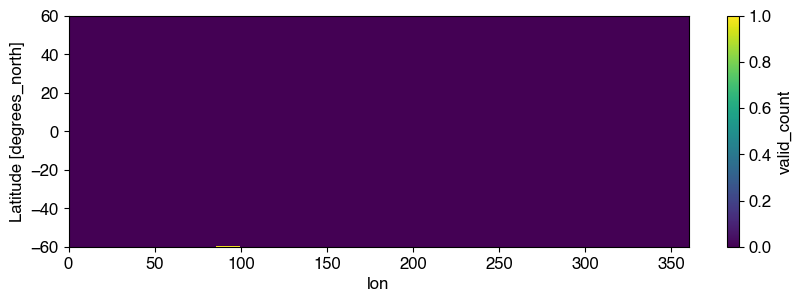

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10,3), dpi=100)
mask_miss.plot(vmin=0, vmax=1, cmap='viridis', ax=ax)

# Read and combine all files to a single DataSet

In [68]:
drop_vars = ['latitude', 'longitude', 'lat', 'lon', 'time']
# Read all files and combine them with a new dimension 'tracker'
ds = xr.open_mfdataset(filenames, combine='nested', concat_dim='tracker', drop_variables=drop_vars).squeeze()
# Assign new coordinate 'source' using name_map dictionary keys
ds['tracker'] = tracker_list
# # Assign lat/lon coordinate from landmask
# ds = ds.assign_coords({'lon': lon_lm, 'lat': lat_lm})

if PHASE == 'Winter':
    ds = ds.roll(lon=1800, roll_coords=True)
    # Convert longitude coordinates from -180~180 to 0~360
    lon360 = ds['lon'].data % 360
    ds = ds.assign_coords(lon=lon360)

# Assign lat/lon coordinate from landmask
ds = ds.assign_coords({'lon': lon_lm, 'lat': lat_lm})

lon = ds.lon
lat = ds.lat
ds

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:                  (tracker: 10, lat: 1200, lon: 3600)
Coordinates:
  * tracker                  (tracker) <U11 'PyFLEXTRKR' 'DL' ... 'ATRACKCS'
  * lon                      (lon) float64 0.05 0.15 0.25 ... 359.8 359.9 359.9
  * lat                      (lat) float64 -59.95 -59.85 -59.75 ... 59.85 59.95
Data variables:
    precipitation            (tracker, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation        (tracker, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation_count  (tracker, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_cloud_count          (tracker, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    ntimes                   (tracker) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Title:       MCS precipitation accumulation
    phase:       Winter
    tracker:     PyFLEXTRKR
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    created_on:  Mon Nov  6 14:43:06 2023

## Function to remove values in DataSet with missing value mask

In [69]:
def apply_2d_mask(dataset, mask, mask_dims=('lat', 'lon')):
    """
    Apply a 2D mask to a dataset, only masking variables that include the mask dimensions.

    Parameters:
    ----------
    dataset : xarray.Dataset
        The dataset to be masked.
    mask : xarray.DataArray
        A 2D mask to apply (e.g., boolean DataArray with the same dimensions as the dataset).
    mask_dims : tuple of str, optional
        The dimensions of the mask (default is ('lat','lon')).

    Returns:
    -------
    xarray.Dataset
        A new dataset with the mask applied to appropriate variables.
    """
    masked_dataset = xr.Dataset()

    for var_name, var in dataset.data_vars.items():
        # Check if the variable includes the mask dimensions
        if set(mask_dims).issubset(var.dims):
            # Apply the mask to variables that have the matching dimensions
            masked_dataset[var_name] = var.where(mask == False)
        else:
            # Keep variables unchanged if dimensions don't match
            masked_dataset[var_name] = var

    # Preserve coordinates
    for coord_name, coord in dataset.coords.items():
        masked_dataset.coords[coord_name] = coord

    return masked_dataset

In [70]:
ds = apply_2d_mask(ds, mask_miss, mask_dims=('tracker','lat','lon'))
ds

<xarray.Dataset>
Dimensions:                  (tracker: 10, lon: 3600, lat: 1200)
Coordinates:
  * tracker                  (tracker) <U11 'PyFLEXTRKR' 'DL' ... 'ATRACKCS'
  * lon                      (lon) float64 0.05 0.15 0.25 ... 359.8 359.9 359.9
  * lat                      (lat) float64 -59.95 -59.85 -59.75 ... 59.85 59.95
Data variables:
    precipitation            (tracker, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation        (tracker, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_precipitation_count  (tracker, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    mcs_cloud_count          (tracker, lat, lon) float32 dask.array<chunksize=(1, 1200, 3600), meta=np.ndarray>
    ntimes                   (tracker) float32 dask.array<chunksize=(1,), meta=np.ndarray>

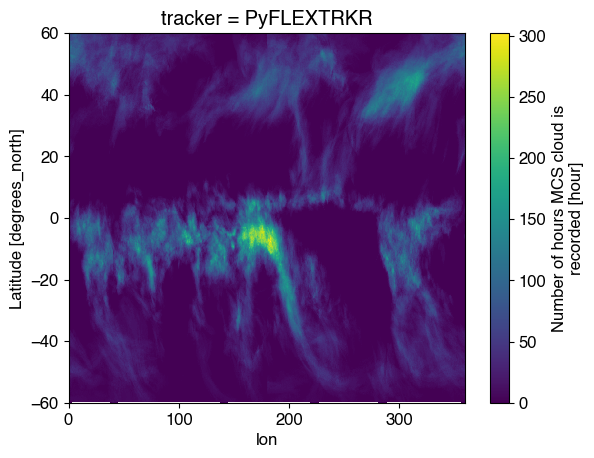

In [71]:
ds.mcs_cloud_count.sel(tracker='PyFLEXTRKR').plot()

## Calculate statistics

In [72]:
# Total number of hours
nhours = ds.ntimes
print(f'Number of total hours')
for key in tracker_list:
    print(f'{key}: {int(nhours.sel(tracker=key).values.item())}')
# Precipitation amount [mm], divided by total number of hours to get [mm/h]
# then x24 to get [mm/day]
totpcp = 24. * ds.precipitation / nhours
mcspcp = 24. * ds.mcs_precipitation / nhours
nonmcspcp = totpcp - mcspcp
# MCS precipitation fraction
mcspcpfrac = 100 * mcspcp / totpcp

# Number of hours with MCS precipitation/cloud
mcspcphours = ds.mcs_precipitation_count
mcscloudhours = ds.mcs_cloud_count
# MCS precipitation mean intensity (conditional mean)
mcspcpmeanintensity = ds.mcs_precipitation / mcspcphours

# MCS precipitation frequency
mcspcpfreq = 100 * (mcspcphours / nhours)
mcscloudfreq = 100 * (mcscloudhours / nhours)

Number of total hours
PyFLEXTRKR: 672
DL: 672
MOAAP: 672
TOOCAN: 672
tobac: 672
TIMPS: 672
simpleTrack: 672
KFyAO: 672
TAMS: 672
ATRACKCS: 672


In [73]:
# fig, axes = plt.subplots(2, 1, figsize=(10,8), dpi=100)
# mcscloudfreq.sel(tracker='PyFLEXTRKR').plot(vmin=0, vmax=40, cmap=cc.cm.CET_L19, ax=axes[0])
# mcscloudfreq.sel(tracker='TOOCAN').plot(vmin=0, vmax=40, cmap=cc.cm.CET_L19, ax=axes[1])
# fig.tight_layout()

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


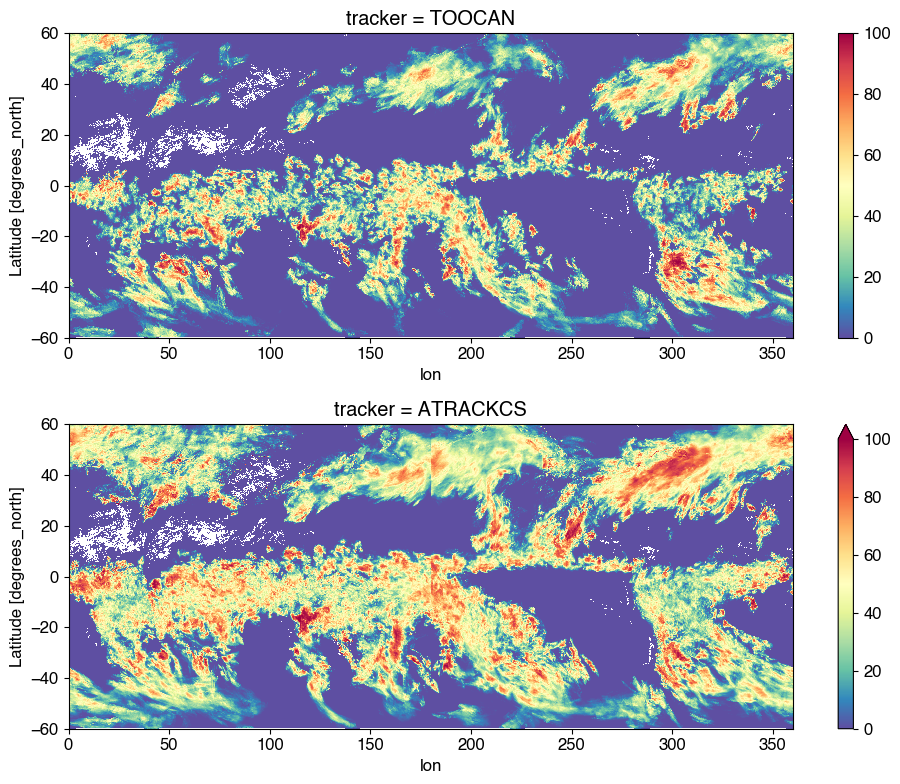

In [74]:
fig, axes = plt.subplots(2, 1, figsize=(10,8), dpi=100)
# mcspcpfrac.sel(tracker='PyFLEXTRKR').plot(vmin=0, vmax=100, cmap='Spectral_r', ax=axes[0])
mcspcpfrac.sel(tracker='TOOCAN').plot(vmin=0, vmax=100, cmap='Spectral_r', ax=axes[0])
mcspcpfrac.sel(tracker='ATRACKCS').plot(vmin=0, vmax=100, cmap='Spectral_r', ax=axes[1])
fig.tight_layout()

## Separate ocean vs. land

In [75]:
# Ocean vs. Land threshold (%)
ocean_thresh = 99
land_thresh = 20

totpcp_o = totpcp.where(landmask >= ocean_thresh)
totpcp_l = totpcp.where(landmask <= land_thresh)
mcspcp_o = mcspcp.where(landmask >= ocean_thresh)
mcspcp_l = mcspcp.where(landmask <= land_thresh)

mcscloudfreq_o = mcscloudfreq.where(landmask >= ocean_thresh)
mcscloudfreq_l = mcscloudfreq.where(landmask <= land_thresh)

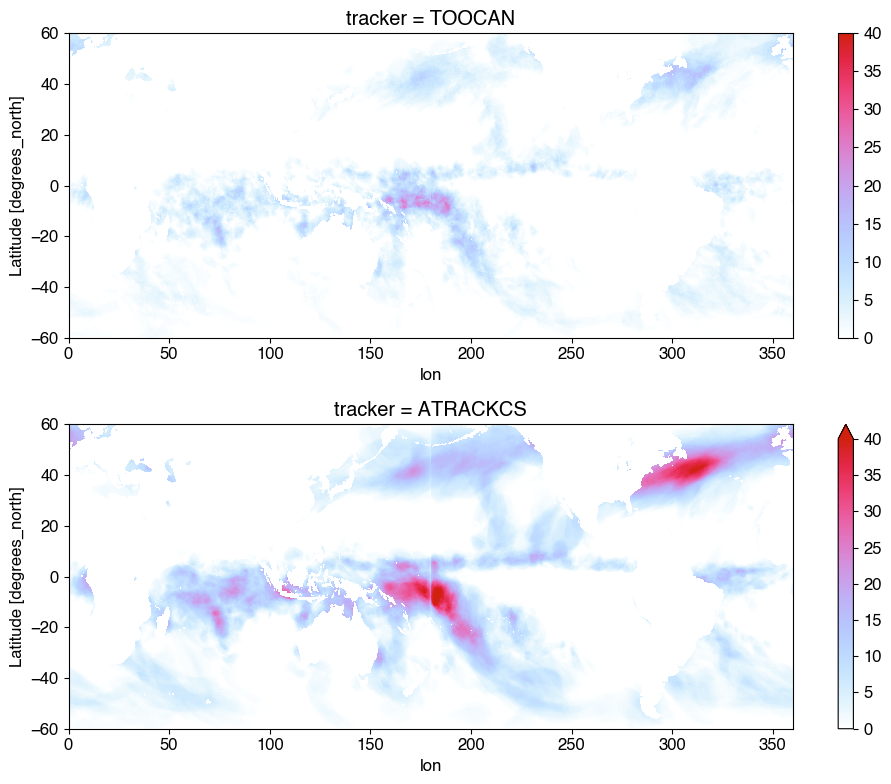

In [76]:
fig, axes = plt.subplots(2, 1, figsize=(10,8), dpi=100)
# mcscloudfreq_o.sel(tracker='PyFLEXTRKR').plot(vmin=0, vmax=40, cmap=cc.cm.CET_L19, ax=axes[0])
mcscloudfreq_o.sel(tracker='TOOCAN').plot(vmin=0, vmax=40, cmap=cc.cm.CET_L19, ax=axes[0])
mcscloudfreq_o.sel(tracker='ATRACKCS').plot(vmin=0, vmax=40, cmap=cc.cm.CET_L19, ax=axes[1])

fig.tight_layout()

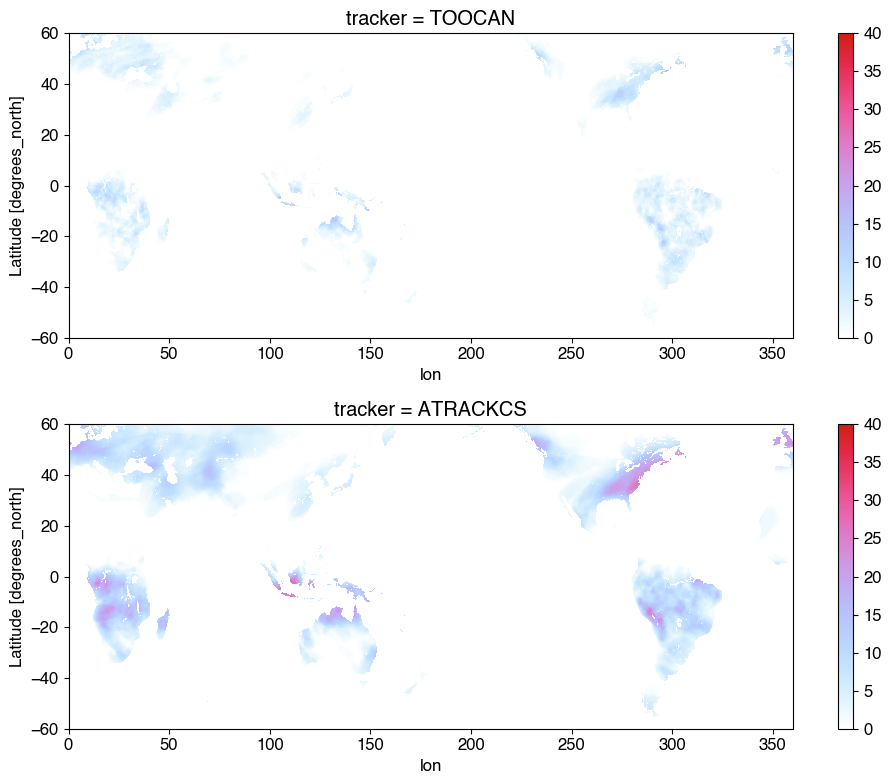

In [78]:
fig, axes = plt.subplots(2, 1, figsize=(10,8), dpi=100)
# mcscloudfreq_o.sel(tracker='PyFLEXTRKR').plot(vmin=0, vmax=40, cmap=cc.cm.CET_L19, ax=axes[0])
mcscloudfreq_l.sel(tracker='TOOCAN').plot(vmin=0, vmax=40, cmap=cc.cm.CET_L19, ax=axes[0])
mcscloudfreq_l.sel(tracker='ATRACKCS').plot(vmin=0, vmax=40, cmap=cc.cm.CET_L19, ax=axes[1])

fig.tight_layout()

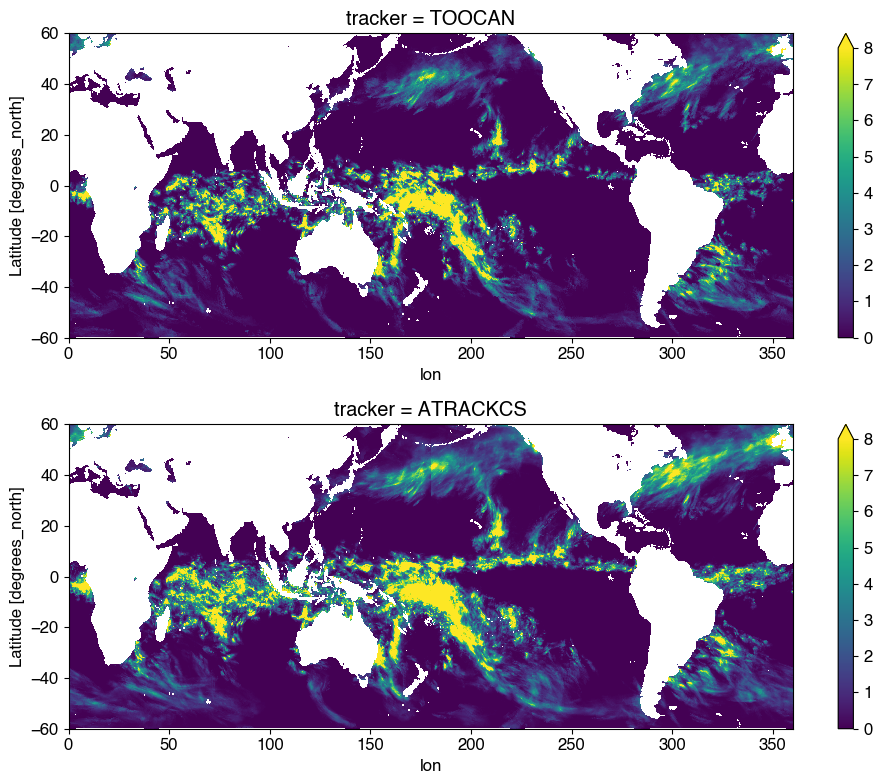

In [77]:
fig, axes = plt.subplots(2, 1, figsize=(10,8), dpi=100)
# mcspcp_o.sel(tracker='PyFLEXTRKR').plot(vmin=0, vmax=8, cmap='viridis', ax=axes[0])
mcspcp_o.sel(tracker='TOOCAN').plot(vmin=0, vmax=8, cmap='viridis', ax=axes[0])
mcspcp_o.sel(tracker='ATRACKCS').plot(vmin=0, vmax=8, cmap='viridis', ax=axes[1])

fig.tight_layout()

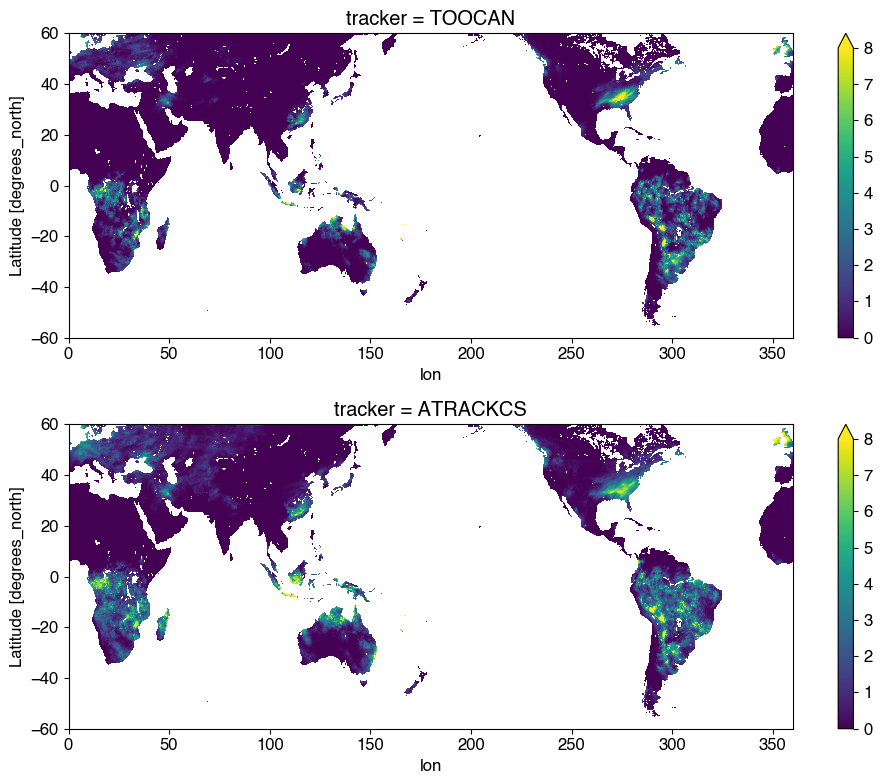

In [79]:
fig, axes = plt.subplots(2, 1, figsize=(10,8), dpi=100)
# mcspcp_o.sel(tracker='PyFLEXTRKR').plot(vmin=0, vmax=8, cmap='viridis', ax=axes[0])
mcspcp_l.sel(tracker='TOOCAN').plot(vmin=0, vmax=8, cmap='viridis', ax=axes[0])
mcspcp_l.sel(tracker='ATRACKCS').plot(vmin=0, vmax=8, cmap='viridis', ax=axes[1])

fig.tight_layout()

## Specify regional boundaries for calculating mean values

In [80]:
if PHASE == 'Summer':
    box_mc = [95,150,-20,5]
    box_itcz = [-179,-70,5,18]
    # box_io = [58,96,-10,5]
    box_io = [50,94,-15,5]
    box_wpac = [125,178,0,30]
    box_sam = [70,125,5,40]
    box_afc = [-15,40,-5,18]
    box_amz = [-75,-45,-15,5]
    box_ao = [-60,-15,5,18]
    box_cus = [-105, -85, 30, 50]
    box_ao180 = [-60,-15,5,18]
    box_cus180 = [-105, -80, 30, 50]
    boxes = {
        'WP':box_wpac,
        'ITCZ':box_itcz, 
        'IO':box_io, 
        'AO':box_ao,
        'AFC':box_afc, 
        'SAM':box_sam,
        'CUS':box_cus,
        'AMZ':box_amz,
    }
    tropics = [-180, 180, -12, 30]
    globe = [-180, 180, -60, 60]
    boxes_globe = {
        'Tropical': tropics,
        'Global': globe,
    }
    region_names = dict(zip(boxes.keys(), boxes.keys()))
    
    # Calculate regional mean difference
    diff_reg = np.zeros(len(boxes), dtype=float)
    text_loc_x = np.zeros(len(boxes), dtype=float)
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    text_loc_y = [
        boxes['WP'][3]+3,
        boxes['ITCZ'][3]+3, 
        boxes['IO'][2]-6, 
        boxes['AO'][3]+3,
        boxes['AFC'][2]-6, 
        boxes['SAM'][3]+3,
        boxes['CUS'][3]+3,
        boxes['AMZ'][2]-6,
    ]
    text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))

In [81]:
if PHASE == 'Winter':
    box_mc = [95%360,150%360,-15,5]
    box_itcz = [151%360,-110%360,0,12]
    box_spcz = [151%360,-150%360,-30,-1]
    box_io = [50%360,94%360,-15,5]
    box_afc = [10%360,40%360,-20,5]
    box_amz = [-75%360,-40%360,-20,0]
    box_ses = [-68%360,-47%360,-40,-21]
    box_ao = [-40%360,-10%360,-8,8]
    boxes = {
        'MC':box_mc, 
        'ITCZ':box_itcz, 
        'SPCZ':box_spcz, 
        'IO':box_io, 
        'AO':box_ao,
        'AFC':box_afc, 
        'AMZ':box_amz,
        'SES':box_ses,
    }
    tropics = [-180, 180, -30, 12]
    globe = [-180, 180, -60, 60]
    boxes_globe = {
        'Tropical': tropics,
        'Global': globe,
    }  
    region_names = dict(zip(boxes.keys(), boxes.keys()))

    # Calculate regional mean difference
    diff_reg = np.zeros(len(boxes), dtype=float)
    text_loc_x = np.zeros(len(boxes), dtype=float)
    for ii, name in enumerate(boxes):
        text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    text_loc_y = [
        boxes['MC'][3]+3,
        boxes['ITCZ'][3]+3,
        boxes['SPCZ'][2]-6, 
        boxes['IO'][2]-6, 
        boxes['AO'][3]+3,
        boxes['AFC'][2]-6, 
        boxes['AMZ'][3]+3, 
        boxes['SES'][2]-6,
    ]
    text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))

In [82]:
text_loc

{'MC': (122.5, 8),
 'ITCZ': (200.5, 15),
 'SPCZ': (180.5, -36),
 'IO': (72.0, -21),
 'AO': (335.0, 11),
 'AFC': (25.0, -26),
 'AMZ': (302.5, 3),
 'SES': (302.5, -46)}

In [83]:
boxes

{'MC': [95, 150, -15, 5],
 'ITCZ': [151, 250, 0, 12],
 'SPCZ': [151, 210, -30, -1],
 'IO': [50, 94, -15, 5],
 'AO': [320, 350, -8, 8],
 'AFC': [10, 40, -20, 5],
 'AMZ': [285, 320, -20, 0],
 'SES': [292, 313, -40, -21]}

## Function to calculate regional mean

In [84]:
def calc_regional_mean(da, boxes):
    """
    Calculate regional mean for all trackers
    Args:
        da: DataArray
            Data Array containing dimensions (tracker, lat, lon)
        boxes: dictionary
            Dictionary containing region names and lat/lon bounds
        
    Returns:
        dict_out: dictionary
            Dictionary containing mean difference for each box.
    """
    # Get number of trackers
    ntracker = da.sizes['tracker']
    # Get number of boxes
    nbox = len(boxes)
    # Get tracker names
    tracker_names = list(da.tracker.data[:])
    
    # Make arrays to store the differences
    mean_reg = np.zeros((ntracker,nbox), dtype=float)
    dict_out = {}
    
    # Loop over each region
    for ii, name in enumerate(boxes):       
        # Select (subset) the region
        ida = da.sel(lon=slice(boxes[name][0], boxes[name][1]), lat=slice(boxes[name][2], boxes[name][3]), drop=True)
        # Average over the region
        mean_reg[:,ii] = ida.mean(dim=('lat','lon'))
        
    # Put values in dictionary
    dict_out = dict(zip(tracker_names, mean_reg))
   
    return dict_out

In [85]:
def calc_regional_mean_frac(da1, da2, boxes):
    """
    Calculate regional mean for all trackers
    Args:
        da1: DataArray
            Data Array1 containing dimensions (tracker, lat, lon)
        da2: DataArray
            Data Array2 containing dimensions (tracker, lat, lon)
        boxes: dictionary
            Dictionary containing region names and lat/lon bounds
        
    Returns:
        dict_out: dictionary
            Dictionary containing mean difference for each box.
    """
    # Get number of trackers
    ntracker = da1.sizes['tracker']
    # Get number of boxes
    nbox = len(boxes)
    # Get tracker names
    tracker_names = list(da1.tracker.data[:])
    
    # Make arrays to store the differences
    mean_reg = np.zeros((ntracker,nbox), dtype=float)
    dict_out = {}
    
    # Loop over each region
    for ii, name in enumerate(boxes):       
        # Select (subset) the region
        ida1 = da1.sel(lon=slice(boxes[name][0], boxes[name][1]), lat=slice(boxes[name][2], boxes[name][3]), drop=True)
        ida2 = da2.sel(lon=slice(boxes[name][0], boxes[name][1]), lat=slice(boxes[name][2], boxes[name][3]), drop=True)
        # Divide sum (da1 / da2) over the region
        mean_reg[:,ii] = 100 * ida1.sum(dim=('lat','lon')) / ida2.sum(dim=('lat','lon'))
        
    # Put values in dictionary
    dict_out = dict(zip(tracker_names, mean_reg))
   
    return dict_out

In [86]:
dict_mcspcpfracAvg = calc_regional_mean_frac(mcspcp, totpcp, boxes)
dict_mcspcpfracAvg

{'PyFLEXTRKR': array([62.13983536, 62.91785812, 76.50287628, 72.44290161, 67.1325531 ,
        59.5459671 , 58.58633041, 74.58143616]),
 'DL': array([63.92615891, 56.78061676, 71.9624939 , 73.78088379, 63.30199432,
        64.26796722, 59.67297745, 47.95774841]),
 'MOAAP': array([43.47464371, 45.94591522, 59.09590149, 52.84103394, 44.75453949,
        37.00462723, 37.70390701, 50.3496933 ]),
 'TOOCAN': array([29.4707756 , 37.5824852 , 48.38227463, 40.04737473, 33.18761063,
        26.60912704, 22.90518188, 54.90370178]),
 'tobac': array([36.10493851, 38.11761856, 41.6322403 , 40.1883049 , 36.84635544,
        29.20948982, 27.3757267 , 45.94556046]),
 'TIMPS': array([49.26451492, 50.93471146, 63.65674973, 59.37923813, 53.14487457,
        44.50074387, 45.27471542, 56.63082886]),
 'simpleTrack': array([55.44831848, 54.97343445, 69.74855804, 64.09546661, 58.30422211,
        56.45098495, 53.7373848 , 63.46031189]),
 'KFyAO': array([51.3222084 , 52.32632446, 68.63075256, 62.0033226 , 55.31

In [87]:
dict_mcspcpfracAvg2 = calc_regional_mean(mcspcpfrac, boxes)
dict_mcspcpfracAvg2

/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/co

{'PyFLEXTRKR': array([54.47694397, 39.51144791, 56.155159  , 66.35413361, 49.24411392,
        52.04883575, 55.00645828, 68.28490448]),
 'DL': array([56.9342804 , 35.42033768, 52.86074829, 68.19687653, 46.38622284,
        57.46608734, 56.96305084, 41.34687805]),
 'MOAAP': array([37.5030098 , 27.66617584, 41.8616333 , 46.86721039, 31.82558632,
        31.54660606, 35.19004822, 45.615345  ]),
 'TOOCAN': array([24.5970726 , 21.83061218, 33.19569397, 33.95771408, 22.35417366,
        22.36731911, 21.05269814, 49.75332642]),
 'tobac': array([30.71389389, 22.2822628 , 30.92655373, 35.82753754, 25.22683907,
        24.9893589 , 25.00437546, 41.15084076]),
 'TIMPS': array([42.17366028, 30.56428528, 44.78606796, 53.00209045, 37.80648041,
        38.13212204, 41.99440765, 50.52300262]),
 'simpleTrack': array([48.25817108, 33.86111069, 50.50430298, 58.1510582 , 42.42380905,
        49.42059326, 50.99777222, 57.88253784]),
 'KFyAO': array([44.19645309, 32.35263824, 49.02506638, 56.2067337 , 39.25

In [88]:
dict_mcscloudfreqAvg = calc_regional_mean(mcscloudfreq, boxes)
dict_mcscloudfreqAvg

{'PyFLEXTRKR': array([ 9.37147713,  5.33476019, 11.64889336,  9.34231186,  5.60550833,
         8.77608585, 10.86809349,  4.71659088]),
 'DL': array([13.24731636,  6.59929037, 14.19714355, 12.68785381,  7.03586674,
        13.26928043, 15.31235886,  4.29826784]),
 'MOAAP': array([7.06374645, 4.13391113, 9.28282547, 7.08512354, 4.23468494,
        5.90400457, 7.83323383, 3.68745542]),
 'TOOCAN': array([3.59352946, 2.67510915, 5.87499332, 4.1046834 , 2.34776473,
        2.91657352, 3.41914082, 3.36842895]),
 'tobac': array([4.59147596, 2.70525956, 5.22217321, 4.31387472, 2.58919263,
        3.34380174, 4.19997454, 2.72599268]),
 'TIMPS': array([6.83838415, 3.96723056, 8.65756035, 6.84320736, 4.0581069 ,
        5.73959732, 7.78891611, 3.432935  ]),
 'simpleTrack': array([ 8.68003082,  4.91218853, 10.98065376,  8.360116  ,  5.10481167,
         8.68812084, 10.40788555,  4.26536942]),
 'KFyAO': array([ 7.9693737 ,  4.77769899, 11.06813717,  8.2380085 ,  4.83758402,
         7.55375242,  8.

In [89]:
dict_mcspcpfracAvg_o = calc_regional_mean_frac(mcspcp_o, totpcp_o, boxes_globe)
dict_mcspcpfracAvg_o

{'PyFLEXTRKR': array([70.65380096, 54.46173477]),
 'DL': array([70.58183289, 46.18949127]),
 'MOAAP': array([52.85238647, 38.20061874]),
 'TOOCAN': array([41.11380386, 31.26698112]),
 'tobac': array([42.06072617, 28.25014114]),
 'TIMPS': array([58.60315323, 41.34914398]),
 'simpleTrack': array([63.00164032, 46.71171951]),
 'KFyAO': array([60.35620499, 44.64411926]),
 'TAMS': array([69.59281158, 48.29131317]),
 'ATRACKCS': array([52.83917999, 41.13920593])}

In [90]:
dict_mcspcpfracAvg_l = calc_regional_mean_frac(mcspcp_l, totpcp_l, boxes_globe)
dict_mcspcpfracAvg_l

{'PyFLEXTRKR': array([55.06887436, 49.69400406]),
 'DL': array([57.23937988, 37.16125488]),
 'MOAAP': array([34.93363953, 27.21656227]),
 'TOOCAN': array([24.42347145, 20.79694939]),
 'tobac': array([26.51360893, 18.63470078]),
 'TIMPS': array([40.51441193, 30.45379829]),
 'simpleTrack': array([51.09842682, 46.15904236]),
 'KFyAO': array([44.92036057, 40.37306213]),
 'TAMS': array([53.54996872, 39.86901474]),
 'ATRACKCS': array([42.53490067, 39.16957474])}

In [91]:
dict_mcscloudfreqAvg_o = calc_regional_mean(mcscloudfreq_o, boxes_globe)
dict_mcscloudfreqAvg_o

{'PyFLEXTRKR': array([6.37295246, 3.4795754 ]),
 'DL': array([8.56835365, 3.80530024]),
 'MOAAP': array([4.97195435, 2.51157618]),
 'TOOCAN': array([2.98679757, 1.61921859]),
 'tobac': array([3.16689849, 1.44432998]),
 'TIMPS': array([4.78829288, 2.36237931]),
 'simpleTrack': array([5.81287909, 3.27431321]),
 'KFyAO': array([5.65791559, 3.07583165]),
 'TAMS': array([9.45311832, 4.61600494]),
 'ATRACKCS': array([7.06961918, 4.04992151])}

In [92]:
dict_mcscloudfreqAvg_l = calc_regional_mean(mcscloudfreq_l, boxes_globe)
dict_mcscloudfreqAvg_l

{'PyFLEXTRKR': array([5.62689447, 3.23991609]),
 'DL': array([8.10347271, 2.80896711]),
 'MOAAP': array([3.91708946, 1.65815496]),
 'TOOCAN': array([1.97081292, 0.98535347]),
 'tobac': array([2.24204135, 0.84451181]),
 'TIMPS': array([3.72903204, 1.53442895]),
 'simpleTrack': array([5.47908926, 3.46867633]),
 'KFyAO': array([4.74605417, 2.84332585]),
 'TAMS': array([8.10950375, 3.72841501]),
 'ATRACKCS': array([6.4976778 , 3.93520331])}

In [93]:
boxes_globe.keys()

dict_keys(['Tropical', 'Global'])

In [94]:
dict_mcspcpfracAvg_global = {}
labels_global = ['Tropical Ocean', 'Tropical Land', 'Global Ocean', 'Global Land']
for key in dict_mcspcpfracAvg_o.keys():
    # Tropics ocean, tropics land, global ocean, global land
    dict_mcspcpfracAvg_global[key] = np.array([dict_mcspcpfracAvg_o[key][0], dict_mcspcpfracAvg_l[key][0], dict_mcspcpfracAvg_o[key][1], dict_mcspcpfracAvg_l[key][1]])

dict_mcspcpfracAvg_global

{'PyFLEXTRKR': array([70.65380096, 55.06887436, 54.46173477, 49.69400406]),
 'DL': array([70.58183289, 57.23937988, 46.18949127, 37.16125488]),
 'MOAAP': array([52.85238647, 34.93363953, 38.20061874, 27.21656227]),
 'TOOCAN': array([41.11380386, 24.42347145, 31.26698112, 20.79694939]),
 'tobac': array([42.06072617, 26.51360893, 28.25014114, 18.63470078]),
 'TIMPS': array([58.60315323, 40.51441193, 41.34914398, 30.45379829]),
 'simpleTrack': array([63.00164032, 51.09842682, 46.71171951, 46.15904236]),
 'KFyAO': array([60.35620499, 44.92036057, 44.64411926, 40.37306213]),
 'TAMS': array([69.59281158, 53.54996872, 48.29131317, 39.86901474]),
 'ATRACKCS': array([52.83917999, 42.53490067, 41.13920593, 39.16957474])}

In [95]:
dict_mcscloudfreqAvg_global = {}
labels_global = ['Tropical Ocean', 'Tropical Land', 'Global Ocean', 'Global Land']
for key in dict_mcscloudfreqAvg_o.keys():
    # Tropics ocean, tropics land, global ocean, global land
    dict_mcscloudfreqAvg_global[key] = np.array([dict_mcscloudfreqAvg_o[key][0], dict_mcscloudfreqAvg_l[key][0], dict_mcscloudfreqAvg_o[key][1], dict_mcscloudfreqAvg_l[key][1]])

dict_mcscloudfreqAvg_global

{'PyFLEXTRKR': array([6.37295246, 5.62689447, 3.4795754 , 3.23991609]),
 'DL': array([8.56835365, 8.10347271, 3.80530024, 2.80896711]),
 'MOAAP': array([4.97195435, 3.91708946, 2.51157618, 1.65815496]),
 'TOOCAN': array([2.98679757, 1.97081292, 1.61921859, 0.98535347]),
 'tobac': array([3.16689849, 2.24204135, 1.44432998, 0.84451181]),
 'TIMPS': array([4.78829288, 3.72903204, 2.36237931, 1.53442895]),
 'simpleTrack': array([5.81287909, 5.47908926, 3.27431321, 3.46867633]),
 'KFyAO': array([5.65791559, 4.74605417, 3.07583165, 2.84332585]),
 'TAMS': array([9.45311832, 8.10950375, 4.61600494, 3.72841501]),
 'ATRACKCS': array([7.06961918, 6.4976778 , 4.04992151, 3.93520331])}

## Function to plot 1 map and 1 bar chart

In [96]:
# def plot_map_bars(data_map, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
#                   oob_colors=None, contourf=False, figsize=None, fontsize=None, cb_fontsize=None,
#                   boxes=None, boxtextloc=None, boxtext=None, boxtexttype=None, text_colors=None,
#                   bar_data=None, bar_width=None, bar_ylabel=None, legend_prop=None, bar_ylim=None, bar_yticks=None,):
#                   # boxes=None, boxtextloc=None, dict_text_type=None, dict_text_val=None, text_colors=None, boxtext_fontsize=None):
    
#     mpl.rcParams['font.size'] = fontsize
#     mpl.rcParams['font.family'] = 'Helvetica'

#     ###################################################
#     # Map plot
#     ###################################################
#     map_extent = [-180., 179.5, -60.1, 60.1]
#     lonv = np.arange(-180,180.1,30)
#     latv = np.arange(-60,60.1,15)
#     proj = ccrs.PlateCarree(central_longitude=0)
#     data_proj = ccrs.PlateCarree()
#     levelshgt = [1000,10000]

#     fig = plt.figure(figsize=figsize, dpi=100)
#     h_ratios = [0.05, 1, 1]
#     gs = gridspec.GridSpec(3, 1, height_ratios=h_ratios, width_ratios=[1])
#     gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.3)

#     resolution = '110m'
#     land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
#     ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
#     borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
#     ax = plt.subplot(gs[1,0], projection=proj)
#     ax.set_extent(map_extent, crs=proj)
#     ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
#     ax.set_aspect('auto', adjustable=None)
#     ax.set_title(titles[0], loc='left')
    
#     # Grid lines & labels
#     gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
#     gl.xlocator = mpl.ticker.FixedLocator(lonv)
#     gl.ylocator = mpl.ticker.FixedLocator(latv)         
#     # if (row == nrow-1):
#     ax.set_xticks(lonv, crs=data_proj)
#     lon_formatter = LongitudeFormatter(zero_direction_label=True)
#     ax.xaxis.set_major_formatter(lon_formatter)
#     ax.set_yticks(latv, crs=data_proj)
#     lat_formatter = LatitudeFormatter()
#     ax.yaxis.set_major_formatter(lat_formatter)

#     # Terrain height
#     ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
#                     colors='dimgray', linewidths=1, transform=data_proj, zorder=3)
    
#     # Select and mask data source
#     Zm = np.ma.masked_where(np.isnan(data_map), data_map)
#     cmap = copy.copy(mpl.colormaps.get_cmap(cmaps))
#     # Set out-of-bounds colors
#     if oob_colors is not None:
#         cmap.set_over(oob_colors['over'])
#         cmap.set_under(oob_colors['under'])
#         # cf1.set_clim(min(levels), max(levels))
#     norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
#     # Plot data
#     if (contourf == False):
#         cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
#     else:
#         cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)
#     # # Set out-of-bounds colors
#     # if oob_colors is not None:
#     #     cf1.cmap.set_over(oob_colors['over'])
#     #     cf1.cmap.set_under(oob_colors['under'])
#     #     cf1.set_clim(min(levels), max(levels))
#     # Colorbars
#     cax1 = plt.subplot(gs[0,0])
#     cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels, ticks=cbticks, orientation='horizontal', extend='both')
#     cb1.ax.xaxis.set_label_position('top')
#     cb1.ax.tick_params(labelsize=cb_fontsize)
        
#     # Plot boxes
#     if boxes is not None:
#         for ii in boxes:
#             # Plot region boxes
#             corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
#             box = Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=10)
#             ax.add_patch(box)

#             if boxtexttype is None:
#                 text_color = text_colors['pos'] if (boxtext[ii] >=0) else text_colors['neg']
#                 ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]:.00f}%", ha='center',
#                         bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
#                         fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
#             else:
#                 text_color = 'k'
#                 ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]}", ha='center',
#                         bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
#                         fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)

    
#     ###################################################
#     # Bar chart
#     ###################################################
#     ax2 = plt.subplot(gs[2,0])
#     labels = list(boxes.keys())
#     x = np.arange(len(labels))
#     multiplier = -((len(tracker_list)-1)/2)
#     lcolors = {
#         'PyFLEXTRKR':'royalblue', 
#         'MOAAP': 'darkorange',
#         'TOOCAN': 'gold', 
#         'tobac': 'cyan',
#         'TAMS': 'violet', 
#         'simpleTrack': 'lightseagreen',
#         'DL': 'blueviolet',
#         'KFyAO': 'peru',
#         'ATRACKCS': 'lime',
#     }

#     # Loop over each source    
#     for key, val in bar_data.items():
#         offset = bar_width * multiplier
#         rects = ax2.bar(x + offset, val, bar_width, color=lcolors[key], label=key)
#         multiplier += 1

#     # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax2.set_ylabel(bar_ylabel)
#     ax2.set_title(titles[1], loc='left')
#     ax2.set_xticks(x, labels)
#     ax2.set_yticks(bar_yticks)
#     ax2.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'])
#     ax2.axhline(y=0, lw=1, ls='--', color='k')
#     ax2.grid(which='major', ls='--', axis='y')
#     ax2.set_ylim(bar_ylim[0], bar_ylim[1])
    
#     fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
#     return fig

In [97]:
# if PHASE == 'Summer':
#     panel_numbers = ['(a)', '(c)']
# elif PHASE == 'Winter':
#     panel_numbers = ['(b)', '(d)']
# print(panel_numbers)

In [98]:
# figsize = [12,11]
# fontsize = 14
# cb_fontsize = 12
# varname1 = 'MCS Rain Fraction'
# varname2 = 'MCS Rain Fraction'
# units = '%'

# # Map data
# tracker = 'PyFLEXTRKR'
# data_map = mcspcpfrac.sel(tracker=tracker)
# levels = np.arange(0, 90.01, 10)
# cmaps = generate_NCL_cmap('WhiteBlueGreenYellowRed')
# cmaps = truncate_colormap(cmaps, 0.0, 0.9)
# titles = [f'{panel_numbers[0]} {varname1} ({source}) [{PHASE}, {tracker}]', f'{panel_numbers[1]} Regional Mean {varname1} ({source}) [{PHASE}]']
# cbticks = levels
# oob_colors = {'under':'white', 'over':'magenta'}
# cblabels = f'{varname1} ({units})'
# text_colors = None
# text_val = dict(zip(boxes.keys(),boxes.keys()))

# # Bar chart data
# bar_data = dict_mcspcpfracAvg
# bar_ylabel = f'{varname2} (%)'
# bar_ylim = (0,90)
# bar_yticks = np.arange(0, 91, 10)
# legend_prop = {'ncol':int(len(tracker_list)/2), 'fontsize':11}
# bar_width = 0.08

# figname = f'{figdir}globalmap_mcs_rainfrac_{source}_barchart_regionalmean.png'

# fig = plot_map_bars(data_map, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
#                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
#                     boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
#                     bar_data=bar_data, bar_width=bar_width, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_yticks=bar_yticks)

## Function to plot 1 map and 2 bar charts

In [99]:
# Compute average valid data fraction over SE Pacific
avg_validfrac_SEPacific = valid_frac.sel({'lon':slice(-120.,-90.),'lat':slice(-60,-50)}).mean().item()
avg_validfrac_SEPacific

nan

In [100]:
def plot_map_2bars(data_map, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                  oob_colors=None, contourf=False, figsize=None, fontsize=None, cb_fontsize=None,
                  boxes=None, boxtextloc=None, boxtext=None, boxtexttype=None, text_colors=None,
                  bar_data=None, bar_width=None, bar_xlabel=None, bar_ylabel=None, legend_prop=None, bar_ylim=None, bar_yticks=None,
                  bar_data2=None, bar_width2=None, bar_xlabel2=None, bar_ylabel2=None, bar_ylim2=None, bar_yticks2=None,
                  bar_avg_data=None, bar_avg_data2=None,
                  mask=None,
                  ):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    ###################################################
    # Map plot
    ###################################################
    map_extent = [-180., 179.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=figsize, dpi=100)
    h_ratios = [0.05, 1, 1, 1]
    gs = gridspec.GridSpec(4, 1, height_ratios=h_ratios, width_ratios=[1])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.3)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    ax = plt.subplot(gs[1,0], projection=proj)
    ax.set_extent(map_extent, crs=proj)
    ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
    ax.set_aspect('auto', adjustable=None)
    ax.set_title(titles[0], loc='left')
    
    # Grid lines & labels
    gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
    gl.xlocator = mpl.ticker.FixedLocator(lonv)
    gl.ylocator = mpl.ticker.FixedLocator(latv)         
    # if (row == nrow-1):
    ax.set_xticks(lonv, crs=data_proj)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_yticks(latv, crs=data_proj)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

    # Terrain height
    ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                    colors='dimgray', linewidths=1, transform=data_proj, zorder=3)
    
    # Select and mask data source
    Zm = np.ma.masked_where(np.isnan(data_map), data_map)
    cmap = copy.copy(mpl.colormaps.get_cmap(cmaps))
    # Set out-of-bounds colors
    if oob_colors is not None:
        cmap.set_over(oob_colors['over'])
        cmap.set_under(oob_colors['under'])
        # cf1.set_clim(min(levels), max(levels))
    norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    # Plot data
    if (contourf == False):
        cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
    else:
        cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)
    # # Set out-of-bounds colors
    # if oob_colors is not None:
    #     cf1.cmap.set_over(oob_colors['over'])
    #     cf1.cmap.set_under(oob_colors['under'])
    #     cf1.set_clim(min(levels), max(levels))

    # Mask missing data region
    if (mask is not None):
        cmap_zmask = mpl.colors.ListedColormap(['white','lightgray','lightgray'])
        norm_zmask = mpl.colors.BoundaryNorm(np.arange(0,2.1,1), cmap_zmask.N)
        Zm = np.ma.masked_where(mask == False, mask)
        cm = ax.pcolormesh(lon, lat, Zm, cmap=cmap_zmask, norm=norm_zmask, transform=data_proj, zorder=2)
        if (avg_validfrac_SEPacific < miss_frac):
            ax.text(-110, -54, f'Missing Data > {miss_frac:.0f}%', color='k', ha='center', va='center', transform=proj, zorder=3)
    
    # Colorbars
    cax1 = plt.subplot(gs[0,0])
    cb1 = plt.colorbar(cf1, cax=cax1, label=cblabels, ticks=cbticks, orientation='horizontal', extend='both')
    cb1.ax.xaxis.set_label_position('top')
    cb1.ax.tick_params(labelsize=cb_fontsize)
        
    # Plot boxes
    if boxes is not None:
        for ii in boxes:
            # Plot region boxes
            corners = [[boxes[ii][0],boxes[ii][2]], [boxes[ii][1],boxes[ii][2]], [boxes[ii][1],boxes[ii][3]], [boxes[ii][0],boxes[ii][3]]]
            box = Polygon(corners, edgecolor='k', facecolor='none', lw=2, transform=data_proj, zorder=10)
            ax.add_patch(box)

            if boxtexttype is None:
                text_color = text_colors['pos'] if (boxtext[ii] >=0) else text_colors['neg']
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]:.00f}%", ha='center',
                        bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                        fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)
            else:
                text_color = 'k'
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]}", ha='center',
                        bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                        fontsize=12, fontweight='bold', color=text_color, transform=data_proj, zorder=4)

    
    ###################################################
    # Bar chart 1
    ###################################################
    ax2 = plt.subplot(gs[2,0])
    # labels = list(boxes.keys())
    x = np.arange(len(bar_xlabel))
    multiplier = -((len(tracker_list)-1)/2)
    lcolors = {
        'PyFLEXTRKR':'royalblue', 
        'MOAAP': 'darkorange',
        'TOOCAN': 'gold', 
        'tobac': 'cyan',
        'TAMS': 'violet', 
        'simpleTrack': 'lightseagreen',
        'DL': 'dodgerblue',
        'KFyAO': 'peru',
        'TIMPS': 'springgreen',
        'ATRACKCS': 'blueviolet',
    }

    # Loop over each source
    offset_save = {}
    for key, val in bar_data.items():
        offset = bar_width * multiplier
        rects = ax2.bar(x + offset, val, bar_width, color=lcolors[key], label=key)
        multiplier += 1
        offset_save[key] = x + offset  # Save x positions for each bar
        
    # Calculate bar groups min/max x position
    bar_x_min = np.min(np.stack(list(offset_save.values())), axis=0)
    bar_x_max = np.max(np.stack(list(offset_save.values())), axis=0)
    # Plot horizontal lines for average values
    ax2.hlines(y=bar_avg_data, xmin=bar_x_min, xmax=bar_x_max, color='k', lw=1)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_ylabel(bar_ylabel)
    ax2.set_title(titles[1], loc='left')
    ax2.set_xticks(x, bar_xlabel)
    ax2.set_yticks(bar_yticks)
    ax2.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'])
    ax2.axhline(y=0, lw=1, ls='--', color='k')
    ax2.grid(which='major', ls='--', axis='y')
    ax2.set_ylim(bar_ylim[0], bar_ylim[1])
    
    
    ###################################################
    # Bar chart 2
    ###################################################
    ax3 = plt.subplot(gs[3,0])
    # labels = list(labels_global.keys())
    x = np.arange(len(bar_xlabel2))
    multiplier = -((len(tracker_list)-1)/2)
    
    # Loop over each source
    offset_save = {}
    for key, val in bar_data2.items():
        offset = bar_width2 * multiplier
        rects = ax3.bar(x + offset, val, bar_width2, color=lcolors[key], label=key)
        multiplier += 1
        offset_save[key] = x + offset  # Save x positions for each bar
    
    # Calculate bar groups min/max x position
    bar_x_min = np.min(np.stack(list(offset_save.values())), axis=0)
    bar_x_max = np.max(np.stack(list(offset_save.values())), axis=0)
    # Plot horizontal lines for average values
    ax3.hlines(y=bar_avg_data2, xmin=bar_x_min, xmax=bar_x_max, color='k', lw=1)
        
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax3.set_ylabel(bar_ylabel2)
    ax3.set_title(titles[2], loc='left')
    ax3.set_xticks(x, bar_xlabel2)
    ax3.set_yticks(bar_yticks2)
    ax3.legend(ncol=legend_prop['ncol'], fontsize=legend_prop['fontsize'])
    ax3.axhline(y=0, lw=1, ls='--', color='k')
    ax3.grid(which='major', ls='--', axis='y')
    ax3.set_ylim(bar_ylim2[0], bar_ylim2[1])
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [101]:
if PHASE == 'Summer':
    panel_numbers = ['(a)', '(c)', '(e)']
elif PHASE == 'Winter':
    panel_numbers = ['(b)', '(d)', '(f)']
print(panel_numbers)

['(b)', '(d)', '(f)']


/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_cloudfreq_OBS_barchart_globalmean.png


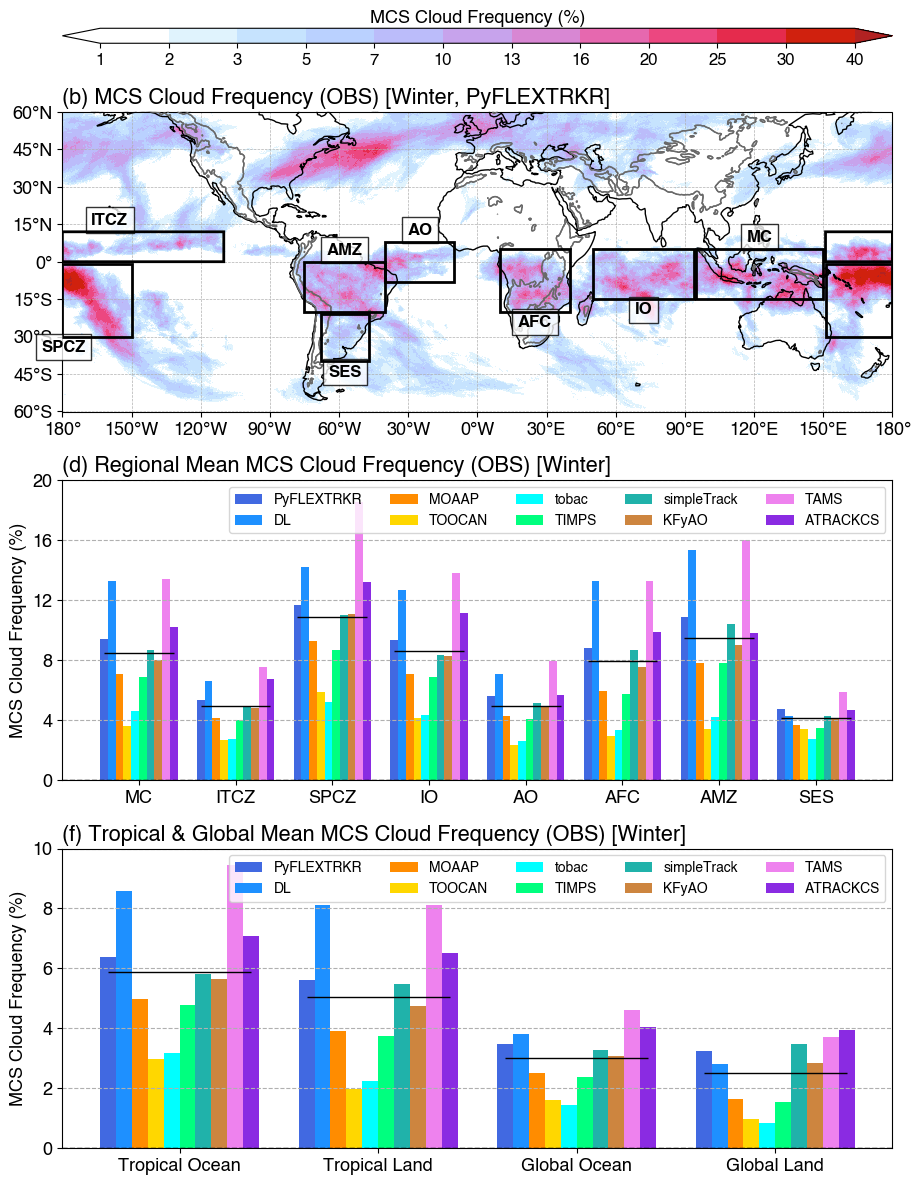

In [102]:
figsize = [10,14]
fontsize = 13
cb_fontsize = 12
varname1 = 'MCS Cloud Frequency'
varname2 = 'MCS Cloud Frequency'
units = '%'

# Stack all arrays and calculate the mean along axis 0
mcscloudfreqAvg_trackerMean = np.mean(np.stack(list(dict_mcscloudfreqAvg.values())), axis=0)
dict_mcscloudfreqAvg_global_trackerMean = np.mean(np.stack(list(dict_mcscloudfreqAvg_global.values())), axis=0)

# Map data
tracker = 'PyFLEXTRKR'
data_map = mcscloudfreq.sel(tracker=tracker)
levels = [1,2,3,5,7,10,13,16,20,25,30,40]
cmaps = cc.cm.CET_L19
titles = [f'{panel_numbers[0]} {varname1} ({source}) [{PHASE}, {tracker}]', 
          f'{panel_numbers[1]} Regional Mean {varname1} ({source}) [{PHASE}]',
          f'{panel_numbers[2]} Tropical & Global Mean {varname1} ({source}) [{PHASE}]',]
cbticks = levels
oob_colors = {'under':'white', 'over':'firebrick'}
cblabels = f'{varname1} ({units})'
text_colors = None
text_val = dict(zip(boxes.keys(),boxes.keys()))

# Bar chart data
bar_data = dict_mcscloudfreqAvg
bar_avg_data = mcscloudfreqAvg_trackerMean
bar_xlabel = boxes.keys()
bar_ylabel = f'{varname2} (%)'
bar_ylim = (0,20)
bar_yticks = np.arange(0, 20.1, 4)
legend_prop = {'ncol':int(np.ceil(len(tracker_list)/2)), 'fontsize':10}
bar_width = 0.08

# Bar chart data 2
bar_data2 = dict_mcscloudfreqAvg_global
bar_avg_data2 = dict_mcscloudfreqAvg_global_trackerMean
bar_xlabel2 = labels_global
bar_ylabel2 = f'{varname2} (%)'
bar_ylim2 = (0,10)
bar_yticks2 = np.arange(0, 11, 2)
bar_width2 = 0.08

figname = f'{figdir}globalmap_mcs_cloudfreq_{source}_barchart_globalmean.png'
print(figname)
fig = plot_map_2bars(data_map, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
                    bar_data=bar_data, bar_width=bar_width, bar_xlabel=bar_xlabel, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_yticks=bar_yticks,
                    bar_data2=bar_data2, bar_width2=bar_width2, bar_xlabel2=bar_xlabel2, bar_ylabel2=bar_ylabel2, bar_ylim2=bar_ylim2, bar_yticks2=bar_yticks2,
                    bar_avg_data=bar_avg_data, bar_avg_data2=bar_avg_data2, mask=mask_miss,
                    )

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_rainfrac_OBS_barchart_globalmean.png


/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


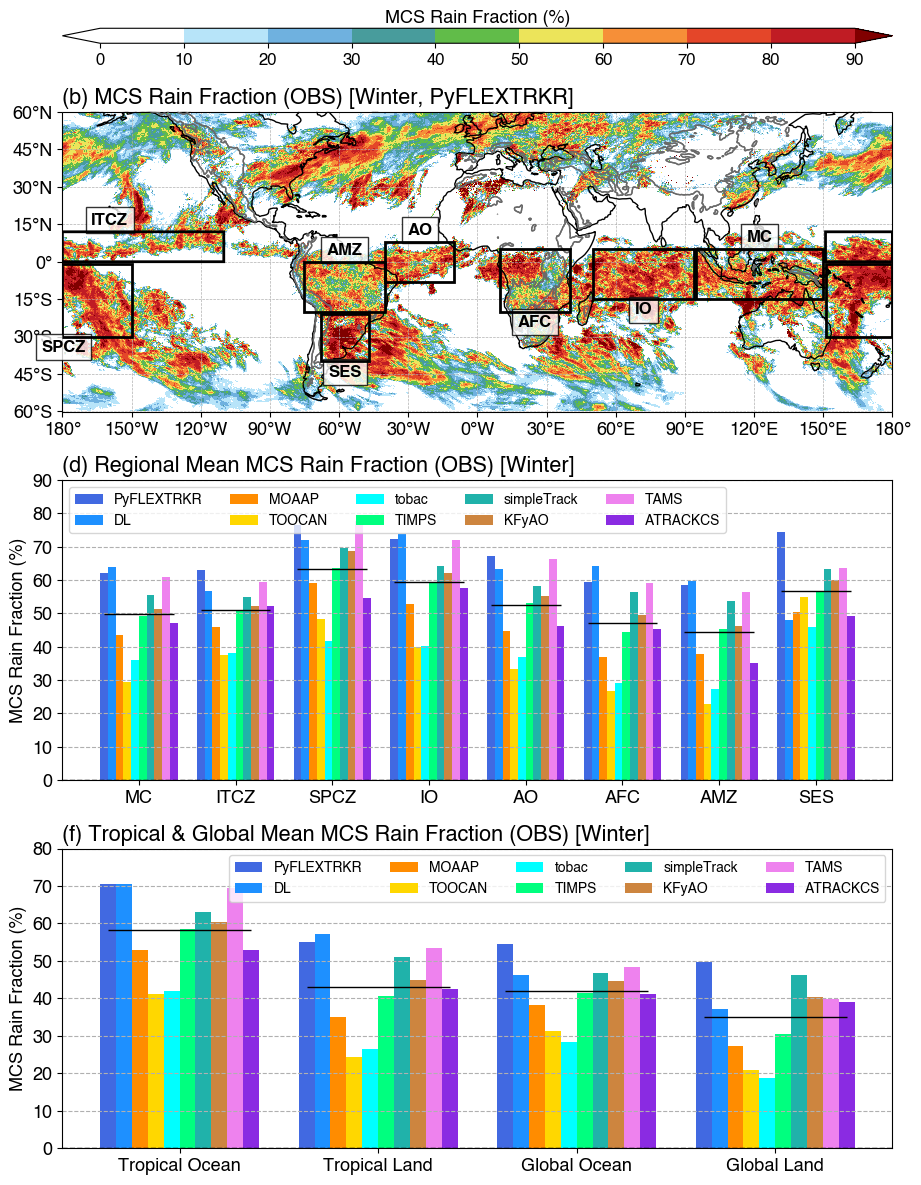

In [103]:
figsize = [10,14]
fontsize = 13
cb_fontsize = 12
varname1 = 'MCS Rain Fraction'
varname2 = 'MCS Rain Fraction'
units = '%'

# Stack all arrays and calculate the mean along axis 0
dict_mcspcpfracAvg_trackerMean = np.mean(np.stack(list(dict_mcspcpfracAvg.values())), axis=0)
dict_mcspcpfracAvg_global_trackerMean = np.mean(np.stack(list(dict_mcspcpfracAvg_global.values())), axis=0)

# Map data
tracker = 'PyFLEXTRKR'
data_map = mcspcpfrac.sel(tracker=tracker)
levels = np.arange(0, 90.01, 10)
cmaps = generate_NCL_cmap('WhiteBlueGreenYellowRed')
cmaps = truncate_colormap(cmaps, 0.0, 0.9)
titles = [f'{panel_numbers[0]} {varname1} ({source}) [{PHASE}, {tracker}]', 
          f'{panel_numbers[1]} Regional Mean {varname1} ({source}) [{PHASE}]',
          f'{panel_numbers[2]} Tropical & Global Mean {varname1} ({source}) [{PHASE}]',]
cbticks = levels
oob_colors = {'under':'white', 'over':'maroon'}
cblabels = f'{varname1} ({units})'
text_colors = None
text_val = dict(zip(boxes.keys(),boxes.keys()))

# Bar chart data
bar_data = dict_mcspcpfracAvg
bar_avg_data = dict_mcspcpfracAvg_trackerMean
bar_xlabel = boxes.keys()
bar_ylabel = f'{varname2} (%)'
bar_ylim = (0,90)
bar_yticks = np.arange(0, 91, 10)
legend_prop = {'ncol':int(np.ceil(len(tracker_list)/2)), 'fontsize':10}
bar_width = 0.08

# Bar chart data 2
bar_data2 = dict_mcspcpfracAvg_global
bar_avg_data2 = dict_mcspcpfracAvg_global_trackerMean
bar_xlabel2 = labels_global
bar_ylabel2 = f'{varname2} (%)'
bar_ylim2 = (0,80)
bar_yticks2 = np.arange(0, 81, 10)
bar_width2 = 0.08

figname = f'{figdir}globalmap_mcs_rainfrac_{source}_barchart_globalmean.png'
print(figname)
fig = plot_map_2bars(data_map, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                    figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, 
                    boxes=boxes, boxtextloc=text_loc, boxtext=text_val, boxtexttype='string',
                    bar_data=bar_data, bar_width=bar_width, bar_xlabel=bar_xlabel, bar_ylabel=bar_ylabel, legend_prop=legend_prop, bar_ylim=bar_ylim, bar_yticks=bar_yticks,
                    bar_data2=bar_data2, bar_width2=bar_width2, bar_xlabel2=bar_xlabel2, bar_ylabel2=bar_ylabel2, bar_ylim2=bar_ylim2, bar_yticks2=bar_yticks2,
                    bar_avg_data=bar_avg_data, bar_avg_data2=bar_avg_data2, mask=mask_miss,
                    )

In [45]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_rainfrac_OBS_barchart_globalmean.png'

## Function to plot multiple panels

In [104]:
def plot_maps_nrow(nrow, ncol, da, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                   oob_colors=None, contourf=False, figsize=None, fontsize=None, cb_fontsize=None, show_cb2=False, figtitle=None, mask=None,):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extent = [-180., 179.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=figsize, dpi=100)
    # Setup two columns (left: plots, right: colorbar)
    gs0 = gridspec.GridSpec(1, 2, figure=fig, height_ratios=[1], width_ratios=[1,0.02], wspace=0.05)
    # Setup panels to the left
    h_ratios = list(np.repeat(1,nrow))
    w_ratios = list(np.repeat(1,ncol))
    gs = gridspec.GridSpecFromSubplotSpec(nrow, ncol, subplot_spec=gs0[0], height_ratios=h_ratios, width_ratios=w_ratios, wspace=0.02, hspace=0.05)
    
    # Loop over each panel (DataArray dimension 'tracker')
    for pp in range(da.sizes['tracker']):
        ax = plt.subplot(gs[pp], projection=proj)
        ax.set_extent(map_extent, crs=proj)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_aspect('auto', adjustable=None)
        # Title
        flabel = ax.text(0.02, 0.07, titles[pp], transform=ax.transAxes, fontsize=None)
        flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
        
        # Grid lines & labels
        gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
        # gl.xlocator = mpl.ticker.FixedLocator(lonv)
        # gl.ylocator = mpl.ticker.FixedLocator(latv)         
        # if (row == nrow-1):
        #     ax.set_xticks(lonv, crs=data_proj)
        #     lon_formatter = LongitudeFormatter(zero_direction_label=True)
        #     ax.xaxis.set_major_formatter(lon_formatter)
        # ax.set_yticks(latv, crs=data_proj)
        # lat_formatter = LatitudeFormatter()
        # ax.yaxis.set_major_formatter(lat_formatter)
        
        # Terrain height
        ct = ax.contour(lon_ter, lat_ter, ter_s, levels=levelshgt, \
                        colors='dimgray', linewidths=0.5, transform=data_proj, zorder=3)
        
        # Select and mask data source
        Var = da.isel(tracker=pp).data
        Zm = np.ma.masked_where(np.isnan(Var), Var)
        cmap = copy.copy(mpl.colormaps.get_cmap(cmaps))
        # Set out-of-bounds colors
        if oob_colors is not None:
            oob_c = oob_colors
            if oob_c is not None:
                cmap.set_over(oob_c['over'])
                cmap.set_under(oob_c['under'])
        norm = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
        # Plot data
        if (contourf == False):
            cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
        else:
            cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)

        # Fill missing Tb data region
        if (mask is not None):
            cmap_zmask = mpl.colors.ListedColormap(['white','lightgray','lightgray'])
            norm_zmask = mpl.colors.BoundaryNorm(np.arange(0,2.1,1), cmap_zmask.N)
            Zm = np.ma.masked_where(mask == False, mask)
            cm = ax.pcolormesh(lon, lat, Zm, cmap=cmap_zmask, norm=norm_zmask, transform=data_proj, zorder=2)
            # ax.text(-120, -54, 'Missing Data', color='k', ha='center', va='center', transform=proj, zorder=3)

    # Colorbar
    cax = plt.subplot(gs0[1])
    cbar = plt.colorbar(cf1, cax=cax, label=cblabels, ticks=cbticks, orientation='vertical', extend='both')
    # Suptitle
    fig.suptitle(figtitle, y=0.92)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [105]:
if PHASE == 'Summer':
    panel_number = '(a)'
elif PHASE == 'Winter':
    panel_number = '(b)'
print(panel_number)

(b)


/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_cloudfreq_OBS_alltrackers.png


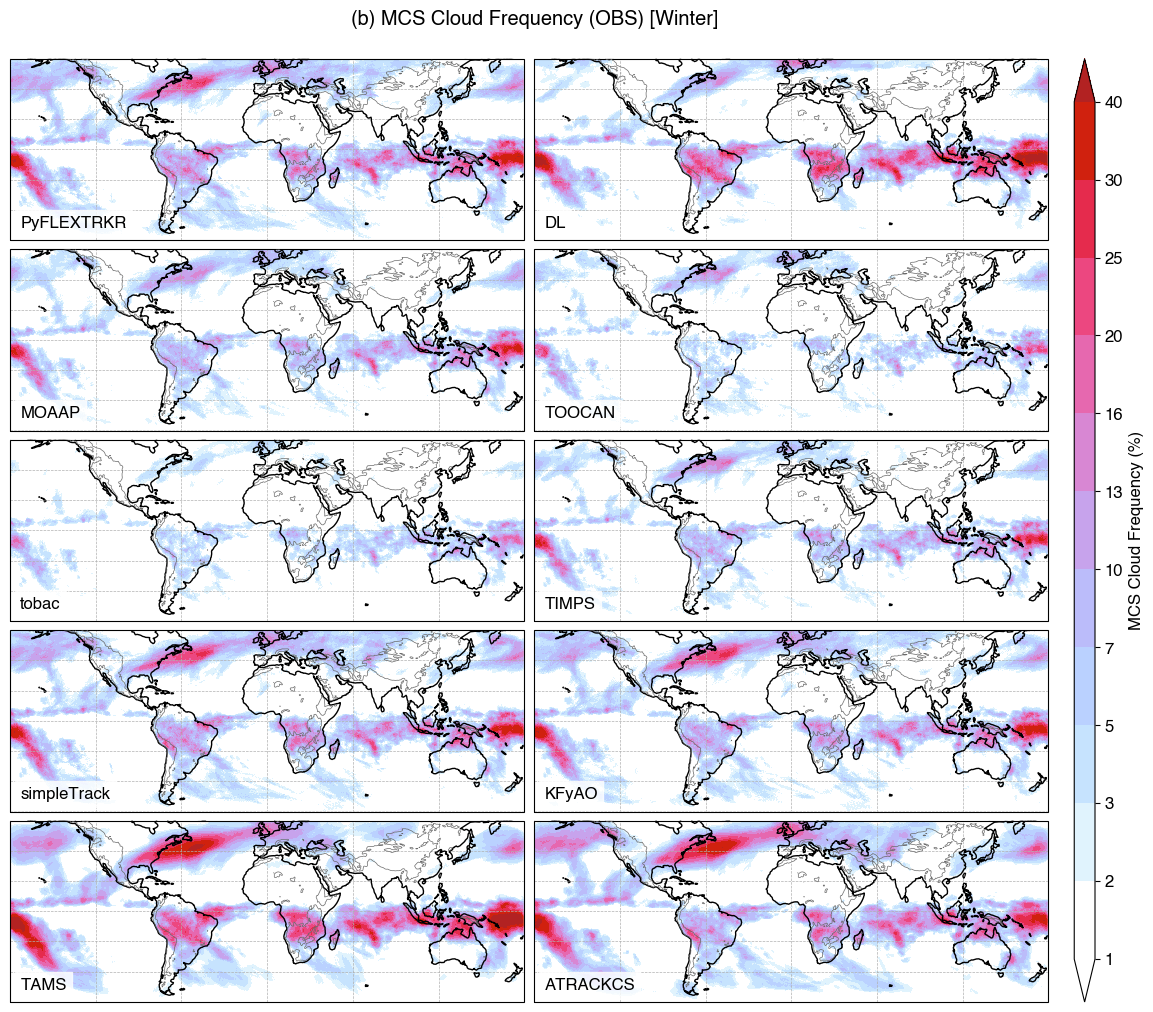

In [106]:
ncol = 2
nsource = len(tracker_list)
nrow = np.ceil(nsource / ncol).astype(int)

figwidth = 14
height_ratio_per_panel = 0.35
figheight = nrow * (figwidth / ncol) * height_ratio_per_panel
figsize = [figwidth,figheight]
fontsize = 12
cb_fontsize = 10
varname1 = 'MCS Cloud Frequency'
units = '%'

# Select variable to plot
da = mcscloudfreq
levels = [1,2,3,5,7,10,13,16,20,25,30,40]
cmaps = cc.cm.CET_L19
titles = tracker_list
figtitle = f'{panel_number} MCS Cloud Frequency ({source}) [{PHASE}]'

cbticks = levels
oob_colors = {'under':'white', 'over':'firebrick'}
cblabels = f'{varname1} ({units})'
figname = f'{figdir}globalmap_mcs_cloudfreq_{source}_alltrackers.png'
print(figname)
fig = plot_maps_nrow(nrow, ncol, da, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, figtitle=figtitle,
                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, show_cb2=False, mask=mask_miss)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/MCSMIP/globalmap_mcs_rainfrac_OBS_alltrackers.png


/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/common/software/m1867/python/py310/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/global/co

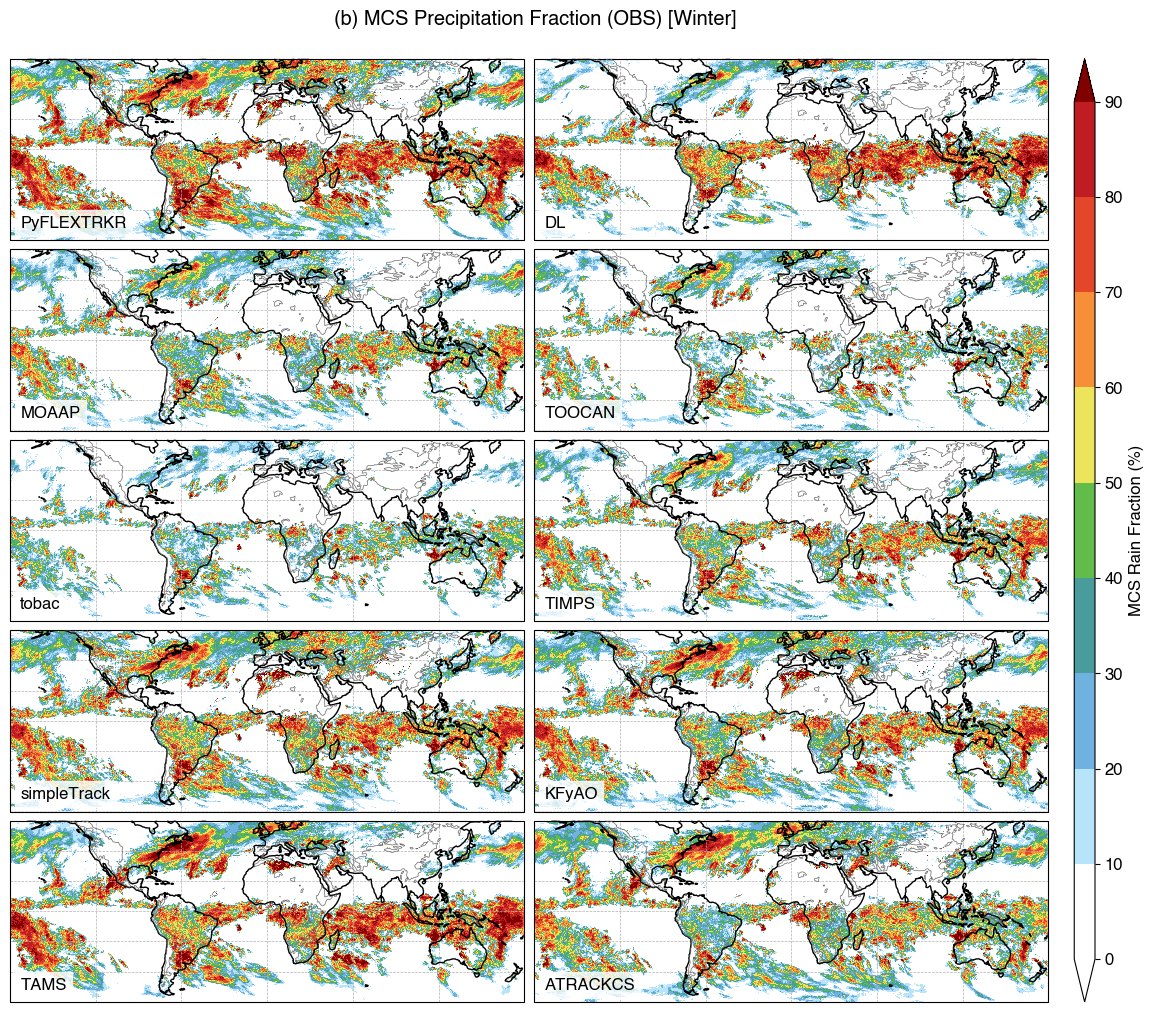

In [107]:
ncol = 2
nsource = len(tracker_list)
nrow = np.ceil(nsource / ncol).astype(int)

figwidth = 14
height_ratio_per_panel = 0.35
figheight = nrow * (figwidth / ncol) * height_ratio_per_panel
figsize = [figwidth,figheight]
fontsize = 12
cb_fontsize = 10
varname1 = 'MCS Rain Fraction'
units = '%'

# Select variable to plot
da = mcspcpfrac
levels = np.arange(0, 90.01, 10)
cmaps = generate_NCL_cmap('WhiteBlueGreenYellowRed')
cmaps = truncate_colormap(cmaps, 0.0, 0.9)
titles = tracker_list
figtitle = f'{panel_number} MCS Precipitation Fraction ({source}) [{PHASE}]'

cbticks = levels
oob_colors = {'under':'white', 'over':'maroon'}
cblabels = f'{varname1} ({units})'
figname = f'{figdir}globalmap_mcs_rainfrac_{source}_alltrackers.png'
print(figname)
fig = plot_maps_nrow(nrow, ncol, da, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, figtitle=figtitle,
                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, show_cb2=False, mask=mask_miss)

In [ ]:
figname

In [ ]:
# # import matplotlib.pyplot as plt
# # import numpy as np

# x = np.arange(10)
# y = np.random.rand(10, 8)  # Random data for 8 series

# lcolors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
#           'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

# for i in range(8):
#     plt.plot(x, y[:, i], label=f'Series {i+1}', color=lcolors[i])

# plt.legend()
# plt.show()
